# Confirmatory Factor Analysis (CFA) in Python
This notebook replicates an SPSS SEM analysis using Python (`semopy`).
It compares one-factor and three-factor models of the Celebrity Worship Scale,
computes reliability (Cronbach's alpha), and interprets model fit indices.


In [34]:
## 1) Get your data into Colab
from google.colab import files
uploaded = files.upload()  # choose your file; e.g., celebrity_worship.csv or data.sav


Saving celebrity_worship_dataset.csv to celebrity_worship_dataset (1).csv


In [18]:
## 2) Install the needed libraries (run once per notebook)
!pip install --quiet pandas numpy seaborn matplotlib factor-analyzer semopy pingouin pyreadstat


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 666.4/666.4 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 7.2 MB/s eta 0:00:00


In [20]:
## 3) Load your dataset (CSV)
import pandas as pd

# If using Option A (uploaded):
df = pd.read_csv("celebrity_worship_dataset.csv")  # adjust filename

df.head()

,Subject No,Age,Sex,Domicile,Domicile_Category,ES1,ES2,ES3,ES4,ES5,...,IP10,IP11,IP12,IP13,BP1,BP2,BP3,BP4,BP5,BP6
0,1,21,Female,Banten,Java Island,4,3,3,3,3,...,2,2,2,2,2,3,2,2,2,2
1,3,20,Female,Jakarta,Java Island,4,4,4,4,3,...,2,3,3,2,1,2,2,3,1,2
2,4,33,Female,Banten,Java Island,5,5,5,5,5,...,5,2,4,2,1,2,3,3,2,1
3,5,34,Female,Jakarta,Java Island,5,5,5,5,5,...,4,5,5,3,4,3,1,5,1,1
4,6,38,Female,Banten,Java Island,5,5,5,5,5,...,1,5,3,1,1,1,3,3,1,1


In [35]:
## 4) Define item blocks & clean the data
ES_items = [f"ES{i}" for i in range(1, 8)]       # ES1..ES7
IP_items = [f"IP{i}" for i in range(1, 14)]      # IP1..IP13
BP_items = [f"BP{i}" for i in range(1, 7)]       # BP1..BP6
all_items = ES_items + IP_items + BP_items

# Coerce to numeric and drop rows with missing item values (simple approach)
df[all_items] = df[all_items].apply(pd.to_numeric, errors="coerce")
df = df.dropna(subset=all_items)
df[all_items].head()

,ES1,ES2,ES3,ES4,ES5,ES6,ES7,IP1,IP2,IP3,...,IP10,IP11,IP12,IP13,BP1,BP2,BP3,BP4,BP5,BP6
0,4,3,3,3,3,3,3,4,3,3,...,2,2,2,2,2,3,2,2,2,2
1,4,4,4,4,3,4,4,3,4,2,...,2,3,3,2,1,2,2,3,1,2
2,5,5,5,5,5,5,5,3,5,2,...,5,2,4,2,1,2,3,3,2,1
3,5,5,5,5,5,5,5,3,5,1,...,4,5,5,3,4,3,1,5,1,1
4,5,5,5,5,5,3,5,3,1,2,...,1,5,3,1,1,1,3,3,1,1


In [24]:
print(df.shape)
print(df.columns)
print(df.head())


(897, 31)
Index(['Subject No', 'Age', 'Sex', 'Domicile', 'Domicile_Category', 'ES1',
       'ES2', 'ES3', 'ES4', 'ES5', 'ES6', 'ES7', 'IP1', 'IP2', 'IP3', 'IP4',
       'IP5', 'IP6', 'IP7', 'IP8', 'IP9', 'IP10', 'IP11', 'IP12', 'IP13',
       'BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6'],
      dtype='object')
   Subject No  Age     Sex Domicile Domicile_Category  ES1  ES2  ES3  ES4  \
0           1   21  Female   Banten       Java Island    4    3    3    3   
1           3   20  Female  Jakarta       Java Island    4    4    4    4   
2           4   33  Female   Banten       Java Island    5    5    5    5   
3           5   34  Female  Jakarta       Java Island    5    5    5    5   
4           6   38  Female   Banten       Java Island    5    5    5    5   

   ES5  ...  IP10  IP11  IP12  IP13  BP1  BP2  BP3  BP4  BP5  BP6  
0    3  ...     2     2     2     2    2    3    2    2    2    2  
1    3  ...     2     3     3     2    1    2    2    3    1    2  
2    5  ...     5     2  

In [36]:
## 5) Reliability (Cronbach’s alpha) a statistic that measures internal consistency
## (a kind of reliability) and Internal consistency asks: “Do all the items on this scale measure the same underlying thing?”

import pingouin as pg

# Function to calculate alpha
def alpha_for(items):
    alpha, ci = pg.cronbach_alpha(df[items])
    return alpha

# Function to interpret alpha values
def interpret_alpha(alpha):
    if alpha < 0.6:
        return "Poor internal consistency — not acceptable."
    elif 0.6 <= alpha < 0.7:
        return "Questionable reliability — needs improvement."
    elif 0.7 <= alpha < 0.8:
        return "Acceptable reliability — generally considered okay."
    elif 0.8 <= alpha < 0.9:
        return "Good reliability — well within accepted standards."
    else:
        return "Excellent reliability — very high internal consistency."

# Calculate for each scale
alpha_es = round(alpha_for(ES_items), 3)
alpha_ip = round(alpha_for(IP_items), 3)
alpha_bp = round(alpha_for(BP_items), 3)

# Print with explanation
print(f"Alpha ES: {alpha_es} → {interpret_alpha(alpha_es)}")
print(f"Alpha IP: {alpha_ip} → {interpret_alpha(alpha_ip)}")
print(f"Alpha BP: {alpha_bp} → {interpret_alpha(alpha_bp)}")


Alpha ES: 0.932 → Excellent reliability — very high internal consistency.
Alpha IP: 0.896 → Good reliability — well within accepted standards.
Alpha BP: 0.754 → Acceptable reliability — generally considered okay.


KMO Overall: 0.951
Bartlett’s χ²: 12707.82 p: 0.0


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


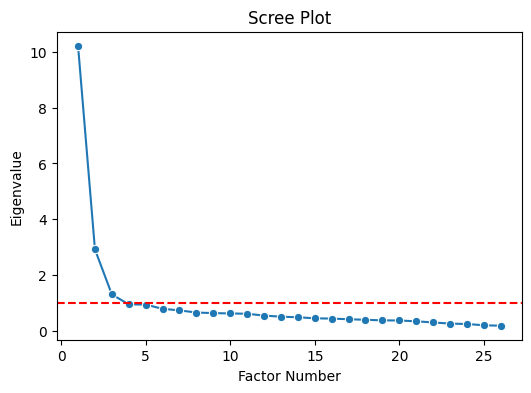

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,F1,F2,F3
ES1,0.855,-0.093,-0.045
ES2,0.820,0.010,0.050
ES3,0.914,-0.073,-0.075
ES4,0.879,-0.037,0.016
ES5,0.759,0.038,0.106
ES6,0.834,-0.011,-0.002
ES7,0.726,0.067,0.013
IP1,0.416,0.399,-0.053
IP2,0.670,0.033,0.091
IP3,0.443,0.418,-0.038


In [37]:
## 6) EFA — KMO/Bartlett + Scree + 3-factor pattern (oblimin)
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import seaborn as sns, matplotlib.pyplot as plt

# KMO & Bartlett
kmo_all, kmo_model = calculate_kmo(df[all_items])
chi2, p_value = calculate_bartlett_sphericity(df[all_items])
print("KMO Overall:", round(kmo_model, 3))
print("Bartlett’s χ²:", round(chi2, 2), "p:", p_value)

# Scree plot
fa = FactorAnalyzer(n_factors=len(all_items), rotation=None, method='principal')
fa.fit(df[all_items])
ev, _ = fa.get_eigenvalues()
plt.figure(figsize=(6,4))
sns.lineplot(x=range(1, len(ev)+1), y=ev, marker="o")
plt.axhline(1.0, color='red', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Factor Number"); plt.ylabel("Eigenvalue")
plt.show()

# EFA: 3 factors, oblimin rotation
efa = FactorAnalyzer(n_factors=3, rotation='oblimin', method='principal')
efa.fit(df[all_items])
loadings = pd.DataFrame(efa.loadings_, index=all_items, columns=['F1','F2','F3'])
loadings.round(3)


In [57]:
## 7) CFA — One-factor vs Three-factor (using semopy)
from semopy import Model, calc_stats
from scipy.stats import chi2
import pandas as pd

def load_block(latent, items):
    return f"{latent} =~ " + " + ".join(items)

# 1-factor
one_factor_model = f"""
CW =~ {" + ".join(all_items)}
"""

# 3-factor
three_factor_model = f"""
{load_block("ES", ES_items)}
{load_block("IP", IP_items)}
{load_block("BP", BP_items)}

ES ~~ IP
ES ~~ BP
IP ~~ BP
"""

def fit_and_stats(model_desc, data, estimator="DWLS"):
    m = Model(model_desc, mimic_lavaan=True)
    m.fit(data, obj=estimator)
    stats = calc_stats(m)
    return m, stats

mod1, stats1 = fit_and_stats(one_factor_model,  df[all_items], estimator="DWLS")
mod3, stats3 = fit_and_stats(three_factor_model, df[all_items], estimator="DWLS")

def show_fit(stats, label="Model"):
    out = pd.Series({
        "Model":   label,
        "Chi2":    stats['chi2'].iloc[0],
        "df":      stats['DoF'].iloc[0],
        "p-value": stats['chi2 p-value'].iloc[0],
        "CFI":     stats['CFI'].iloc[0],
        "TLI":     stats['TLI'].iloc[0],
        "RMSEA":   stats['RMSEA'].iloc[0]
    })
    if 'SRMR' in stats.columns:
        out["SRMR"] = stats['SRMR'].iloc[0]
    return out

# Print the fit statistics table
print(pd.concat([show_fit(stats1, "One-factor"),
                 show_fit(stats3, "Three-factor")], axis=1))

# Chi-square diff test
dchi = stats1['chi2'].iloc[0] - stats3['chi2'].iloc[0]
ddf  = stats1['DoF'].iloc[0]  - stats3['DoF'].iloc[0]
p    = 1 - chi2.cdf(dchi, ddf)
print(f"\nChi-square Difference Test:")
print(f"Δχ² = {dchi:.2f}, Δdf = {ddf}, p = {p:.5f}")

# Optional: standardized loadings/covariances
print("\nStandardized Loadings/Covariances for Three-factor Model (first 5 rows):")
print(mod3.inspect(std_est=True).head())

# Print descriptions of the fit statistics at the bottom
print("\n" + "=" * 30)
print("Fit Statistics Descriptions:")
print("=" * 30)
print("Chi2: A test of exact fit. A significant p-value (< 0.05) suggests poor fit. However, this test is sensitive to large sample sizes.")
print("df: The number of independent pieces of information used to calculate the Chi-squared statistic.")
print("p-value: The probability of obtaining the observed Chi-squared statistic (or more extreme) if the model fits the data perfectly.")
print("CFI: Values closer to 1 indicate better fit (typically > 0.90, with > 0.95 considered excellent). This is a Comparative Fit Index, a measure of how much better the model fits compared to a baseline model.")
print("TLI: Values closer to 1 indicate better fit (typically > 0.90, with > 0.95 considered excellent). This is the Tucker-Lewis Index (also known as the Non-Normed Fit Index), similar to CFI but penalizes for model complexity.")
print("RMSEA: Values closer to 0 indicate better fit (typically < 0.08, with < 0.05 considered excellent). This is the Root Mean Square Error of Approximation, a measure of approximate fit.")
if 'SRMR' in calc_stats(mod1).columns: # Check if SRMR is available in stats
     print("SRMR: Values closer to 0 indicate better fit (typically < 0.08). This is the Standardized Root Mean Square Residual, an absolute measure of fit.")

                   0             1
Model     One-factor  Three-factor
Chi2     1982.794623     1152.5227
df               299           296
p-value          0.0           0.0
CFI         0.947371      0.973228
TLI         0.942794      0.970605
RMSEA       0.079278      0.056829

Chi-square Difference Test:
Δχ² = 830.27, Δdf = 3, p = 0.00000

Standardized Loadings/Covariances for Three-factor Model (first 5 rows):
  lval op rval  Estimate  Est. Std  Std. Err    z-value p-value
0  ES1  ~   ES  1.000000  0.737485         -          -       -
1  ES2  ~   ES  1.201833  0.860952  0.045458  26.438153     0.0
2  ES3  ~   ES  1.039053  0.786731  0.043393  23.945417     0.0
3  ES4  ~   ES  1.164233  0.860599  0.044056  26.426226     0.0
4  ES5  ~   ES  1.257153  0.863060  0.047423   26.50933     0.0

Fit Statistics Descriptions:
Chi2: A test of exact fit. A significant p-value (< 0.05) suggests poor fit. However, this test is sensitive to large sample sizes.
df: The number of independent pieces

In [59]:
## 8) Inspect loadings & factor covariances (standardized)
est3 = mod3.inspect(std_est=True)

# Loadings
loadings3 = est3[(est3['op'] == '~') & (est3['lval'].isin(ES_items + IP_items + BP_items))]
display(loadings3[['rval','lval','Estimate','Std. Err','Est. Std','p-value']].sort_values(by='rval')) # Corrected column names

# Factor covariances
covs3 = est3[(est3['op'] == '~~') & (est3['lval'].isin(['ES','IP','BP'])) & (est3['lval'] != est3['rval'])]
display(covs3[['lval','rval','Estimate','Std. Err','Est. Std','p-value']]) # Corrected column names

,rval,lval,Estimate,Std. Err,Est. Std,p-value
25,BP,BP6,0.908483,0.075496,0.488029,0.0
23,BP,BP4,2.022098,0.118517,0.852485,0.0
22,BP,BP3,0.560079,0.075398,0.280210,0.0
21,BP,BP2,0.936485,0.083625,0.446654,0.0
20,BP,BP1,1.000000,-,0.584591,-
24,BP,BP5,0.948601,0.076418,0.507599,0.0
0,ES,ES1,1.000000,-,0.737485,-
1,ES,ES2,1.201833,0.045458,0.860952,0.0
2,ES,ES3,1.039053,0.043393,0.786731,0.0
3,ES,ES4,1.164233,0.044056,0.860599,0.0


,lval,rval,Estimate,Std. Err,Est. Std,p-value
26,ES,IP,0.300893,0.024958,0.767773,0.0
27,ES,BP,0.142362,0.015293,0.456441,0.0
29,IP,BP,0.206146,0.019079,0.794211,0.0


In [66]:
## 9) Targeted modification (BP4 cross-loading on IP)
# Original 3-factor
orig_model = three_factor_model

# Modified: allow BP4 to load on IP; remove BP4 from BP block
mod1_model = f"""
{load_block("ES", ES_items)}
{load_block("IP", IP_items + ["BP4"])}
{load_block("BP", [i for i in BP_items if i != "BP4"])}

ES ~~ IP
ES ~~ BP
IP ~~ BP
"""

mod1, stats_mod1 = fit_and_stats(mod1_model, df[all_items])

print("Original 3-factor:\n", show_fit(stats3, "Three-factor").to_dict())
print("Modified (BP4 on IP):\n", show_fit(stats_mod1, "Three-factor + BP4 on IP").to_dict())

# Δχ² for modification (df reduces by 1 for adding a loading)
chi2_diff = stats3['chi2'].iloc[0] - stats_mod1['chi2'].iloc[0] # Access scalar value
df_diff   = stats3['DoF'].iloc[0]  - stats_mod1['DoF'].iloc[0] # Access scalar value
p = 1 - chi2.cdf(chi2_diff, df=df_diff) # chi2_diff and df_diff are now scalars

print(f"Δχ² = {chi2_diff:.2f}, Δdf = {df_diff}, p = {p:.5f}") # Format scalar values


# New BP4 loading on IP
est_mod1 = mod1.inspect(std_est=True)
bp4_ip = est_mod1[(est_mod1['op'] == '~') & (est_mod1['lval'] == 'BP4') & (est_mod1['rval'] == 'IP')]
display(bp4_ip[['rval','lval','Estimate','Std. Err','Est. Std','p-value']]) # Corrected column names

Original 3-factor:
 {'Model': 'Three-factor', 'Chi2': 1152.522699638909, 'df': 296, 'p-value': 0.0, 'CFI': 0.9732281988387952, 'TLI': 0.9706052858871907, 'RMSEA': 0.05682894297891575}
Modified (BP4 on IP):
 {'Model': 'Three-factor + BP4 on IP', 'Chi2': 952.8479081670572, 'df': 296, 'p-value': 0.0, 'CFI': 0.9794693105062887, 'TLI': 0.9774578578194049, 'RMSEA': 0.04976597880099232}
Δχ² = 199.67, Δdf = 0, p = nan


,rval,lval,Estimate,Std. Err,Est. Std,p-value
20,IP,BP4,1.280717,0.082805,0.677567,0.0


In [70]:
# Attempt to plot the path diagram using semopy's built-in plotting
# Note: This may require graphviz to be installed and can sometimes be basic.
# For publication-quality diagrams, dedicated software or libraries like graphviz directly might be needed.

try:
    # Assuming mod1 is your final preferred model (the modified three-factor model)
    mod1.plot(edge_est = True, node_est = True)
    plt.title("Path Diagram of Modified Three-Factor Model")
    plt.show()
except Exception as e:
    print(f"Could not generate path diagram using semopy plot function: {e}")
    print("Consider using external tools like Graphviz directly or drawing software.")

Could not generate path diagram using semopy plot function: 'Model' object has no attribute 'plot'
Consider using external tools like Graphviz directly or drawing software.


### Bar Plot of Standardized Loadings

A bar plot of the standardized loadings from your final model helps visualize the strength of the relationship between each observed item and its corresponding latent factor.

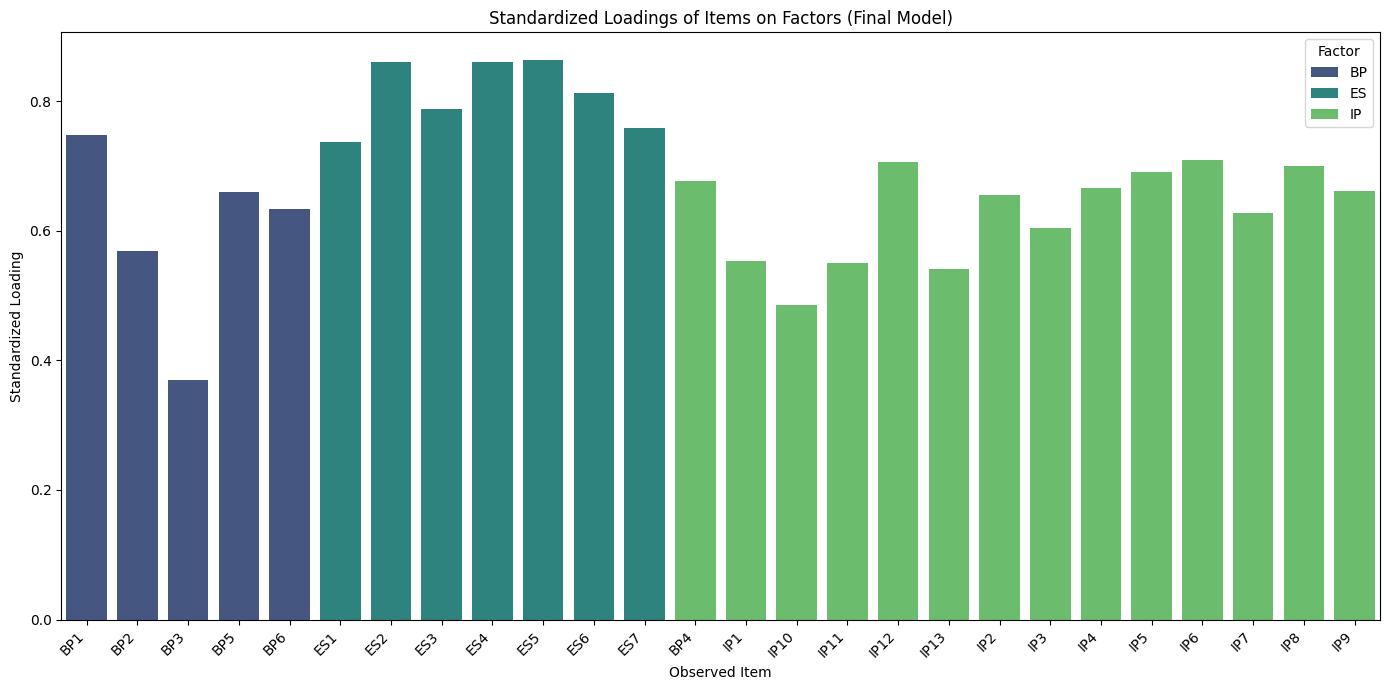

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get standardized estimates from the final model (mod1)
est_final = mod1.inspect(std_est=True)

# Filter for loadings (op == '~') and ensure they are for the item-to-factor relationships
# Assuming items are on the left side (lval) and factors on the right (rval)
loadings_final = est_final[(est_final['op'] == '~') &
                           (est_final['lval'].isin(all_items)) &
                           (est_final['rval'].isin(['ES', 'IP', 'BP']))]

# Sort loadings by factor and then by item name for better visualization
loadings_final = loadings_final.sort_values(by=['rval', 'lval'])

# Create the bar plot
plt.figure(figsize=(14, 7))
sns.barplot(x='lval', y='Est. Std', hue='rval', data=loadings_final, palette='viridis')
plt.title('Standardized Loadings of Items on Factors (Final Model)')
plt.xlabel('Observed Item')
plt.ylabel('Standardized Loading')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Factor')
plt.tight_layout()
plt.show()